Von [Pascal Schlaak](mailto:pascal.schlaak@studmail.htw-aalen.de), [Tim Weise](mailto:tim.weise@studmail.htw-aalen.de) - Natural Language Processing (SoSe 20)

# Verarbeitung aller Dateneinträge

In diesem Notebook soll auf der Analyse eines spezifischen Films aufgebaut werden, indem die Verarbeitung aller gecrawlten Filmdaten untersucht wird. Hierfür bietet es sich an zuerst einen generellen Überblick aller Daten zu verschaffen.

## Module importieren

Zur Verarbeitung der Datenbasis werden folgende Module benötigt und müssen zuerst importiert werden.

In [1]:
import spacy
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

## Daten einlesen

In [2]:
# Pfad zu JSON-Datei
PATH_TO_DATA = '../data/movies.json'
# Einlesen der JSON-Datei in Dictionary
data = pd.read_json(PATH_TO_DATA)

Für eine spätere Transformation mithilfe von Machine Learning bietet sich eine große Menge an Trainingsdaten an. Über die Länge des Dictionarys können wir ausgeben, wie viele Filmeinträge gecrawlt wurden.

In [3]:
number_movies = len(data)
number_movies

250

Diese Anzahl bietet uns eine solide Datenbasis für kommende Verarbeitungsschritte. Neben der Anzahl an Filmeinträgen ist eine höhere Anzahl von Wörtern pro Zusammenfassung ebenfalls von Vorteil, da man somit mehr Informationen über einen bestimmten Film hat. Im Folgenden wird die gesamte Anzahl an Wörtern pro Zusammenfassung mit der effektiv für die Transformation genutzten Anzahl an Wörtern verglichen. Dieser Vergleich bietet uns Einblicke in den Verlust von Wörtern wie beispielsweise Stoppwörtern, welche kein nützliches Wissen für die Analyse des Filminhaltes darstellen.

## Datenbereinigung

In [4]:
data[data.title == 'Modern Times']

,title,date,rank,synopsis
36,Modern Times,1936,52,\n It looks like we don't have ...


In [5]:
data.iloc[36]['synopsis']

'\n                It looks like we don\'t have a Synopsis for this title yet. Be the first to contribute! Just click the "Edit page" button at the bottom of the page or learn more in the Synopsis submission guide.\n            '

In [6]:
disclaimer = 'It looks like we don\'t have a Synopsis for this title yet.'
for index, movie in data.iterrows():
    if disclaimer in movie['synopsis']:
        print(movie['title'])
        data = data.drop(index)

Modern Times
Mein Vater und mein Sohn
The Bandit
High and Low
Capernaum
Come and See
Wild Tales
The Invisible Guest
La Haine
Nausicaä of the Valley of the Wind
The 400 Blows
The Circus
The Kid


In [7]:
len(data)

237


## Analyse der gesamten Rohdaten

Es soll zunächst untersucht werden, wie hoch die mittlere Anzahl an Wörtern, sowie Maxima des gesamten Datensatzes sind. Hierzu untersuchen wir zuerst die gesamte Anzahl an Wörtern inklusive Stoppwörtern. Es werden lediglich die Satzzeichen entfernt. `spaCy` bietet sich wiederrum für eine Tokenisierung der Zusammenfassungen an.

### Gesamte Anzahl an Wörtern

In [8]:
counters = []
# Laden des Sprach-Supports für spätere Analysen wie POS-Tagging
nlp = spacy.load("en_core_web_sm")
# Iteriere über jeden Film in Daten
for index, movie in data.iterrows():
    # Berechnen der Anzahl an Wörtern
    counters.append({'title': movie['title'], 'token': len([token.text for token in nlp(movie['synopsis']) if not token.is_punct])})
total_number_words = pd.DataFrame(counters)

Die Länge einer Liste, welche alle lemmatisierten Tokens enthält, enthält Informationen zur Berechnung der mittleren Anzahl an Wörtern, sowie Identifizierung von minimaler- und maximaler Anzahl an Wörtern einer Zusammenfassung.

In [9]:
# Durchschnittliche Anzahl an Wörtern berechnen
total_average_words = round(sum(total_number_words['token']) / number_movies)
print('Durschnitt:\t{} Wörter'.format(total_average_words))
# Minimale Anzahl an Wörter finden und dessen Filmnamen ausgeben
title_min_total, value_min_total = total_number_words.iloc[total_number_words['token'].argmin()]
print('Minimal:\t{} Wörter\tbei\t{}'.format(value_min_total, title_min_total))
# Maximale Anzahl an Wörter finden und dessen Filmnamen ausgeben
title_max_total, value_max_total = title_min_total, value_min_total = total_number_words.iloc[total_number_words['token'].argmax()]
print('Maximal:\t{} Wörter\tbei\t{}'.format(value_max_total, title_max_total))

Durschnitt:	2080 Wörter
Minimal:	107 Wörter	bei	Neon Genesis Evangelion: The End of Evangelion
Maximal:	11658 Wörter	bei	The Seventh Seal


### Varianz der Daten

Die Varianz unserer Daten könnte ebenfalls interessant sein, um die Streuung der Anzahl an Wörtern pro Zusammenfassung einordnen zu können. Eine Berechnung erfolgt mithilfe von `Numpy`.

In [10]:
np.std(list(total_number_words['token']))

1792.5923023234643

## Analyse der gesamten vorverarbeitenden Daten

Nachdem wir nun einen generellen Überblick unseres gesamten Datensatzes generiert haben, sollen alle Daten auf die für eine Analyse benötigten Daten reduziert werden. Konkret werden ebenfalls neben allen Satzzeichen auch alle Stoppwörter entfernt und die Grundformen der Wörter gebildet. Generell verfahren wir analog zur vorherigen Analyse.

In [11]:
counters = []
# Iteriere über jeden Film in Daten
for index, movie in data.iterrows():
    # Berechnen der Anzahl an Wörtern
    counters.append({'title': movie['title'], 'token': len([token.text for token in nlp(movie['synopsis']) if not token.ent_type_ and not token.is_punct and not token.is_stop])})
reduced_number_words = pd.DataFrame(counters)

In [12]:
reduced_number_words

,title,token
0,The Shawshank Redemption,1458
1,The Dark Knight,2445
2,The Godfather,1176
3,The Godfather: Part II,864
4,Pulp Fiction,682
...,...,...
232,The Wolf of Wall Street,1527
233,Green Book,656
234,Metropolis,796
235,"Three Billboards Outside Ebbing, Missouri",609


In [13]:
# Durchschnittliche Anzahl an Wörtern berechnen
reduced_average_words = round(sum(reduced_number_words['token']) / number_movies)
print('Durschnitt:\t{} Wörter'.format(reduced_average_words))
# Minimale Anzahl an Wörter finden und dessen Filmnamen ausgeben
title_min_reduced, value_min_reduced = reduced_number_words.iloc[reduced_number_words['token'].argmin()]
print('Minimal:\t{} Wörter\tbei\t{}'.format(value_min_reduced, title_min_reduced))
# Maximale Anzahl an Wörter finden und dessen Filmnamen ausgeben
title_max_reduced, value_max_reduced = reduced_number_words.iloc[reduced_number_words['token'].argmax()]
print('Maximal:\t{} Wörter\tbei\t{}'.format(value_max_reduced, title_max_reduced))

Durschnitt:	799 Wörter
Minimal:	38 Wörter	bei	Neon Genesis Evangelion: The End of Evangelion
Maximal:	4634 Wörter	bei	The Seventh Seal


Stoppwörter und Eigennamen machen somit den folgenden Anteil an den gecrawlten Zusammenfassungen aus:

In [14]:
print('~{} %'.format(round((reduced_average_words / total_average_words) * 100, 0)))

~38.0 %


Eine logische Folgerung der Reduzierung unserer Daten, um Stoppwörter, ist die Verringerung der Varianz der Token. Wir können hierfür die Standardabweichung unserer reduzierten Daten bilden.

In [15]:
np.std(list(reduced_number_words['token']))

694.2660992602912

## Worthäufigkeit ohne Eigennamen und Stoppwörter

In [18]:
total_words_without_ents, total_entities = [], []
for index, movie in data.iterrows():
    # Generierung einer Liste von allen lemmatisierten Tokens
    total_words_without_ents.extend([token.lemma_ for token in nlp(movie['synopsis']) if not token.ent_type_ and not token.is_stop and not token.is_punct and token.pos_ != 'VERB'])
    # Generierung einer Liste aller Eigennamen
    total_entities.extend([token.text for token in nlp(movie['synopsis']).ents])

In [19]:
# Häufigesten 30 Wörter identifizieren
common_words = dict(Counter(total_words_without_ents).most_common(20))

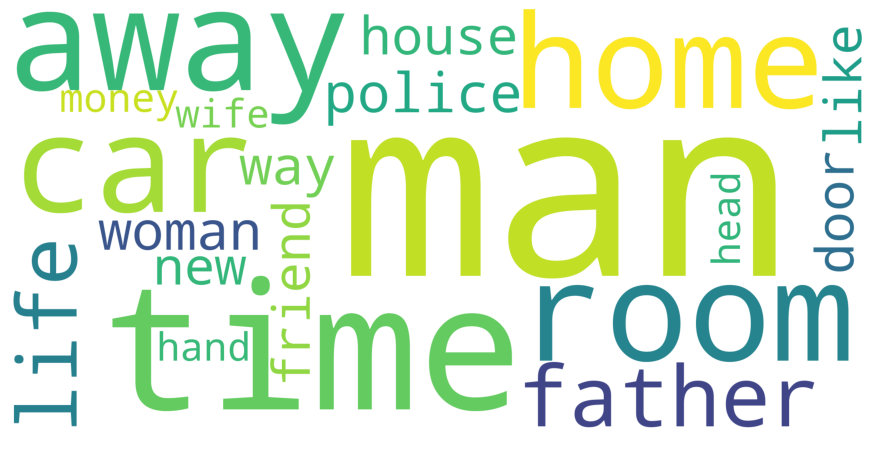

In [20]:
word_cloud = WordCloud(background_color="white", width=2000, height=1000,).generate_from_frequencies(common_words)
plt.rcParams["figure.figsize"] = (16, 8)
plt.axis("off")
plt.imshow(word_cloud)

## Worthäufigkeit der Eigennamen

Nachdem nun generelle Informationen zu den Filminhalten erstellt wurden, können ebenso auch Eigennamen verarbeitet werden. Dies könnte interessant sein, um gängige Rollennamen, Spielorte, Jahr oder Schauspieler identifizieren zu können. In weiteren Analysen könnte beispielsweise versucht werden, die Wahrscheinlichkeit für das Genre eines Films basierend auf dessen Rollen zu bestimmen.

In [ ]:
# Häufigesten 30 Wörter identifizieren
common_entities = dict(Counter(total_entities).most_common(20))

In [ ]:
word_cloud = WordCloud(background_color="white", width=2000, height=1000,).generate_from_frequencies(common_entities)
plt.rcParams["figure.figsize"] = (16, 8)
plt.axis("off")
plt.imshow(word_cloud)

## Fazit

Eine Analyse der Zusammenfassung des Films: Die Verurteilten mit Python, Pandas, spaCy ermöglicht eine Analyse und Reduzierung der Textdaten auf inhaltlich relevante Information. Im folgenden Kapitel soll nun eine Verarbeitung aller Dateneinträge angewendet werden, sowie eine Analyse genereller Information erfolgen.

* [Weiter zu: Verarbeitung aller Dateneinträge](./4_processing_of_all_movies.ipynb)
* [Zurück zur Übersicht](./0_nlp_intro_schlaak_weise.ipynb)